# Quality Factors
## Resonant Circuits and Q-factor
Resonant circuits are used extensively in oscillators, tuned amplifiers, filters, etc. At a particular frequency, _a resonant frequency_ $f_r$ (or $\omega_r$), resonators presents a maximum (or a minimum) impedance (ex: open or short circuit)[1]. The quality factor $Q$, or Q-factor, is a unitless figure of merit of the losses of a resonant passive circuit, defined as [2,3]:

$$
Q = 2 \pi \left. \frac{\textrm{Average Energy Stored}}{\textrm{Energy Loss per Second}} \right|_{\omega=\omega_r}
=
\omega_r \left. \frac{\textrm{Average Energy Stored}}{\textrm{Average Power Loss}} \right|_{\omega=\omega_r}
$$

From this definition, lower loss implies a higher $Q$. Resonators having higher Q-factors resonate with greater amplitudes (at the resonant frequency) but have a smaller range of frequencies $BW$ around that frequency for which they resonate.


## Loaded of Unloaded Q-factors
Actually, there are three Q factors than can be defined depending upon which loss is being considered [2]:

* Unloaded Q: $$Q_0 = \omega_r \left. \frac{\textrm{Energy Stored in the Resonant Circuit}}{\textrm{Power Loss in the Resonant Circuit}} \right|_{\omega=\omega_r}$$

* External Q: $$Q_e = \omega_r \left. \frac{\textrm{Energy Stored in the Resonant Circuit}}{\textrm{Power Loss in the External Circuit}} \right|_{\omega=\omega_r}$$

* Loaded Q: $$Q_L = \omega_r \left. \frac{\textrm{Energy Stored in the Resonant Circuit}}{\textrm{Total Power Loss}} \right|_{\omega=\omega_r}$$

The _loaded_ Q-factor $Q_L$, describes energy dissipation within the entire resonant system comprising of the resonator itself and the instrument used for observing resonances [3]. The term _loading_ refers to the effect that the external circuit has on measured quantities. Any loss mechanisms due to the external circuitry will have the effect of lowering the $Q$.

The _unloaded_ Q-factor $Q_0$ is a characteristic of the resonator itself, in the absence of any loading effects caused by external circuitry (uncoupled). For most applications, the quantity that is desired is the unloaded Q-factor $Q_0$ which is determined by energy dissipation associated with the resonator only and therefore gives the best description of the resonant mode. Direct measurement of the unloaded Q of a resonator is generally not possible because of the loading effect of the measurement system. However, it is possible to estimate $Q_0$ from measurements of the frequency response of the loaded resonator.

The energy dissipation in the external circuit is characterized by the _external_ Q-factor $Q_e$ and these three Q-factors are related by the relationship (deduced from the three expressions above):

$$
\frac{1}{Q_L} = \frac{1}{Q_e} + \frac{1}{Q_0} 
$$

If one defines the _coupling factor_ $\beta=Q_0/Q_e$ then:

$$
Q_0 = (1 + \beta) Q_L
$$

The half-power _fractional bandwidth_ $BW$ (aka 3dB bandwidth) of the resonator is defined by:
$$
BW=\frac{\Delta f}{f_r}
$$

Then

$$
BW = \frac{1}{Q_L}
$$

While the measurements of the loaded Quality factor is straightforward, obtaining uncertainty below 1% (which is considered to be low for Q-factor measurement) requires attention to several aspects of the experimental procedure.

`scikit-rf` implements the methods described in [3] for determining loaded and unloaded Q-factors from frequency-domain S-parameters, that can be applied to measurements of transmission or reflection.

## Example with a Parallel RLC Circuit
To illustrate the usage of the `Qfactor` class of `scikit-rf`, a parallel RLC circuit as illustrated above is used as an canonical example for which analytical formulas are available for benchmarking.
<img src="figures/Parallel_RLC_resonator.svg" width="300"/>

In [1]:
import numpy as np
import skrf as rf
import matplotlib.pyplot as plt
rf.stylely()

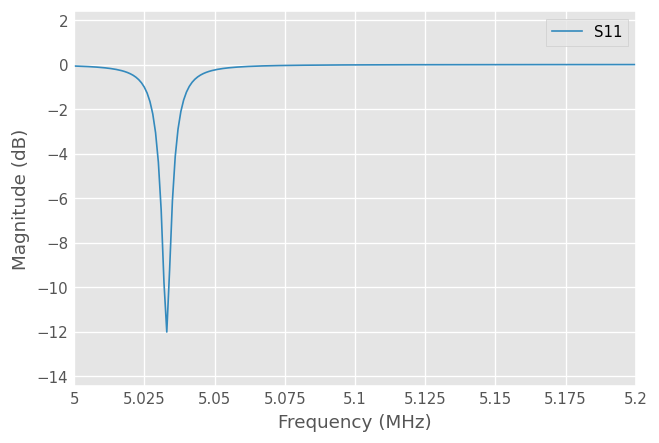

In [2]:
C = 1e-6  # F
L = 1e-9  # H
R = 30  # Ohm

freq = rf.Frequency(5, 5.2, npoints=201, unit='MHz')
media = rf.DefinedGammaZ0(frequency=freq)

resonator = media.line(d=np.random.rand(), unit='rad') \
                **media.shunt_inductor(L) ** media.shunt_capacitor(C) \
                ** media.shunt(media.resistor(R)**media.short()) ** media.open()

resonator.plot_s_db()

Analytical formulas for this case are available and given by [2,3]:
$$ f_{\mathrm{res}} = \frac{1}{2\pi \sqrt{L C}} $$
$$ Q_L = \omega_r C R/2 $$
$$ Q_0 = \omega_r R C $$

In [3]:
def f_res_RLC(L, C):
    return 1/(2*np.pi*np.sqrt(L*C))

def QL_RLC(R, L, C):
    return 2*np.pi*f_res_RLC(L, C) * R * C / 2

def Q0_RLC(R, L, C):
    return 2*np.pi*f_res_RLC(L, C) * R * C

print(f'Theoretical Resonant Frequency: {f_res_RLC(L, C)/1e6} MHz')
print(f'Theoretical Loaded Q: Q_L = {QL_RLC(R, L, C)}')
print(f'Theoretical Unloaded Q: Q_0 = {Q0_RLC(R, L, C)}')

Theoretical Resonant Frequency: 5.032921210448704 MHz
Theoretical Loaded Q: Q_L = 474.34164902525686
Theoretical Unloaded Q: Q_0 = 948.6832980505137


First, let's create a `Qfactor` object, passing the resonator Network and the type of resonator we are dealing with:

In [4]:
Q = rf.Qfactor(resonator, res_type='reflection')

Note that in case of multiple resonances, it is recommanded to also pass the estimated resonance frequency and eventually the estimated (order of magnitude) Q-factor. 

Then, we use the `fit` method to fit the loaded Q-factor $Q_L$ and resonant frequency. The returned results will be usefull to deduce the unloaded Q-factor.

In [5]:
res = Q.fit()
print(f'Fitted Resonant Frequency: f_L = {Q.f_L/1e6} MHz')
print(f'Fitted Loaded Q-factor: Q_L = {Q.Q_L}')

Fitted Resonant Frequency: f_L = [5.03291942] MHz
Fitted Loaded Q-factor: Q_L = [592.92718142]


Finally, the unloaded Q-factor is deduced from the fitting properties: 

In [6]:
Q0 = Q.Q_unloaded(res, A="auto")
print(f'Fitted Unloaded Q-factor: Q_0 = {Q0}')

Fitted Unloaded Q-factor: Q_0 = [948.68353772]


Note that the analytical results and the fitted ones match well, the relative error is small:

In [7]:
print(f'Relative Error on Q_0:', (Q0_RLC(R, L, C) - Q0)/Q0_RLC(R, L, C))

Relative Error on Q_0: [-2.5263137e-07]


## Q-Circle
Close to a resonance, a resonator can be represented by an equivalent circuit model [1,4]. 

The Scattering-parameters (reflection or transmission) of RF circuits including resonator(s) have the form of circles in the complex plane $(\Re(s), \Im(s))$. S-parameters can be expressed as a function of the frequency $f$, the loaded quality factor $Q_L$ [1,4]:

$$
S(f) = S_D + d \frac{e^{-2 j \delta}}{1 + j Q_L \mathcal{F}}
$$

where :
- $S_D$ is the detuned S-parameter measured at frequencies far above or below the resonance
- $Q_L$ is the loaded Q-factor
- $f_L$ is the loaded resonant frequency
- $f_0$ is the unloaded resonant frequency
- $d$ is the diameter of the Q-circle
- $\delta$ is a real valued constant that defines the orientation of the Q-circle
- $\mathcal{F}$ is the fractional offset frequency given by:
$$
\mathcal{F} = \frac{f}{f_L} - \frac{f_L}{f}
$$

The fractional frequency $\mathcal{F}$ is a convenient way to express the frequency when dealing with resonant circuits:  $\mathcal{F}=0$ at the resonant frequency and when $f<f_L$, $\mathcal{F}$ is negative, while it is positive when $f>f_L$. If $\Delta f = f - f_L$ is the frequency deviation from the resonance, then close to the resonance:

$$\mathcal{F} \approx 2 \frac{\Delta f}{f_L}$$

For example, if the source frequency is 10% below the resonant frequency ($0.9 f/f_L$), then $\mathcal{F}\approx -0.2$.

The parameters of the Q-circle are obtained from: 

In [8]:
diam, S_V, S_T = Q.Q_circle(res, A="auto")

Below, the S-parameters of the fitted resonator model is plotted against the RLC resonator: 

In [9]:
np.angle(S_V)

1.8220458592366586

In [10]:
new_freq = rf.Frequency(5, 5.5, npoints=5001, unit='MHz')

s = rf.Qfactor.s_model(new_freq.f, Q.f_L, Q.Q_L, diam, -np.angle(S_V)/2, S_T)
ntwk_model = rf.Network(s=s, frequency=new_freq)

Text(1.8220458592366586, 1.1, '$S_V$')

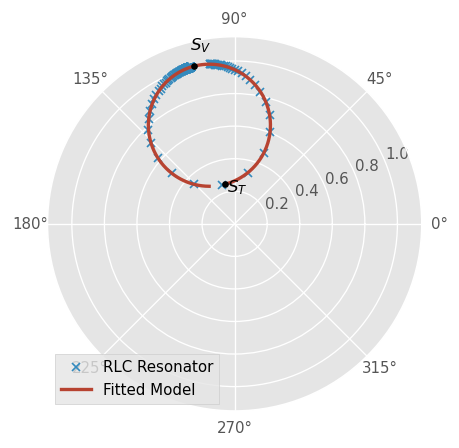

In [11]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
resonator.plot_s_polar(ax=ax, label="RLC Resonator", ls='', marker='x', ms=5)
ntwk_model.plot_s_polar(ax=ax, label="Fitted Model", lw=2)
ax.plot(np.angle(S_V), np.abs(S_V), 'ko')
ax.plot(np.angle(S_T), np.abs(S_T), 'ko')
ax.text(np.angle(S_T), 0.8*np.abs(S_T), '$S_T$')
ax.text(np.angle(S_V), 1.1*np.abs(S_V), '$S_V$')

## References
- [1] B. A. Galwas, "Scattering Matrix Description of Microwave Resonators," in IEEE Transactions on Microwave Theory and Techniques, vol. 31, no. 8, pp. 669-671, Aug. 1983, doi: 10.1109/TMTT.1983.1131566.
- [2] Peter A. Rizzi, "Microwave Engineering: Passive Circuits", Prentice-Hall, 1988 
- [3] David M. Pozar, "Microwave Engineering", 4th Edition, Éditeur	Wiley, 2011
- [4] https://www.microwaves101.com/encyclopedias/resonance-of-rlc-circuits